In [1]:
# Created by Luke Sabor (lukesabor@gmail.com)
# last updated Mar 3, 2021
# This creates and runs othello, also generates Counterfactuals

In [2]:
import random
from PIL import Image
import pandas as pd
import os
from pptx import Presentation
from pptx.util import Inches

In [3]:
#Othello.py
#http://dhconnelly.com/paip-python/docs/paip/othello.html

#The outside edge is marked ?, empty squares are ., black is @, and white is o.
#The black and white pieces represent the two players.
EMPTY, BLACK, WHITE, OUTER = '.', 'Black', 'White', '?'
PIECES = (EMPTY, BLACK, WHITE, OUTER)
PLAYERS = {BLACK: 'Black', WHITE: 'White'}

#To refer to neighbor squares we can add a direction to a square.
UP, DOWN, LEFT, RIGHT = -10, 10, -1, 1
UP_RIGHT, DOWN_RIGHT, DOWN_LEFT, UP_LEFT = -9, 11, 9, -11
DIRECTIONS = (UP, UP_RIGHT, RIGHT, DOWN_RIGHT, DOWN, DOWN_LEFT, LEFT, UP_LEFT)

#List all the valid squares on the board.
def squares():
    return [i for i in range(11, 89) if 1 <= (i % 10) <= 8]

#Create a new board with the initial black and white positions filled.
#The middle four squares should hold the initial piece positions.
def initial_board():
    board = [OUTER] * 100
    for i in squares():
        board[i] = EMPTY
    board[44], board[45] = WHITE, BLACK
    board[54], board[55] = BLACK, WHITE
    return board

#Get a string representation of the board.
def print_board(board):
    rep = ''
    rep += '  %s\n' % ' '.join(map(str, range(1, 9)))
    for row in xrange(1, 9):
        begin, end = 10*row + 1, 10*row + 9
        rep += '%d %s\n' % (row, ' '.join(board[begin:end]))
    return rep

#Images for displaying board nicely
black_sq    = Image.open("black_square.jpeg")
white_sq    = Image.open("white_square.jpeg")
empty_sq    = Image.open("empty_square.jpeg")
outer_sq    = Image.open("boarder_square.jpeg")
square_size = black_sq.size
board_image_size = tuple(8*i for i in square_size)
sq_key = {
    BLACK : black_sq,
    WHITE : white_sq,
    EMPTY : empty_sq,
    OUTER : outer_sq
}
#Displays a nice version of the board. Very legible.
def display_board(board):
    bd = Image.new('RGB', board_image_size)
    for sq in range(len(board)):    
        square = board[sq]
        col    = sq%10
        row    = sq//10
        width  = square_size[0]
        height = square_size[1]
        if (col not in [0,9]) and (row not in [0,9]):
            box    = ((col-1)*width, (row-1)*height, (col)*width, (row)*height)
            bd.paste(sq_key[square],box)
    display(bd)
#Returns a nice version of the board. Very legible.
def return_board(board):
    bd = Image.new('RGB', board_image_size)
    for sq in range(len(board)):    
        square = board[sq]
        col    = sq%10
        row    = sq//10
        width  = square_size[0]
        height = square_size[1]
        if (col not in [0,9]) and (row not in [0,9]):
            box    = ((col-1)*width, (row-1)*height, (col)*width, (row)*height)
            bd.paste(sq_key[square],box)
    return(bd)


#Playing the game
#We need functions to get moves from players, check to make sure that the moves are legal,
#apply the moves to the board, and detect when the game is over.

#Checking moves
#A move must be both valid and legal: it must refer to a real square, and it must form a
#bracket with another piece of the same color with pieces of the opposite color in between.

#Is move a square on the board?

def is_valid(move):
    return isinstance(move, int) and move in squares()

#Get player's opponent piece.
def opponent(player):
    return BLACK if player is WHITE else WHITE

#Find a square that forms a bracket with square for player in the given direction. Returns
#None if no such square exists.
def find_bracket(square, player, board, direction):
    bracket = square + direction
    if board[bracket] == player:
        return None
    opp = opponent(player)
    while board[bracket] == opp:
        bracket += direction
    return None if board[bracket] in (OUTER, EMPTY) else bracket

#Is this a legal move for the player?
def is_legal(move, player, board):
    hasbracket = lambda direction: find_bracket(move, player, board, direction)
    return board[move] == EMPTY and any(map(hasbracket, DIRECTIONS))

#Making moves
#When the player makes a move, we need to update the board and flip all the bracketed pieces.
#Update the board to reflect the move by the specified player.

def make_move(move, player, board):
    board[move] = player
    for d in DIRECTIONS:
        make_flips(move, player, board, d)
    return board

#Flip pieces in the given direction as a result of the move by player.
def make_flips(move, player, board, direction):
    bracket = find_bracket(move, player, board, direction)
    if not bracket:
        return
    square = move + direction
    while square != bracket:
        board[square] = player
        square += direction

#Monitoring players
class IllegalMoveError(Exception):

    def __init__(self, player, move, board):
        self.player = player
        self.move = move
        self.board = board

    def __str__(self):
        return '%s cannot move to square %d' % (PLAYERS[self.player], self.move)

#Get a list of all legal moves for player.
def legal_moves(player, board):
    return [sq for sq in squares() if is_legal(sq, player, board)]

#Can player make any moves?
def any_legal_move(player, board):
    return any(is_legal(sq, player, board) for sq in squares())

#Putting it all together
#Each round consists of:
#Get a move from the current player.
#Apply it to the board.
#Switch players. If the game is over, get the final score.

#Play a game of Othello and return the final board, score, and a record of taken moves.
def play(black_strategy, white_strategy,starting_board = initial_board(),starting_player = BLACK,turn_limit = -1):
    move_record = []
    board = starting_board
    player = starting_player
    strategy = lambda who: black_strategy if who == BLACK else white_strategy
    while (player is not None) and (turn_limit != 0):
        move = get_move(strategy(player), player, board)
        move_record.append(move)
        make_move(move, player, board)
        if not any_legal_move(opponent(player),board):
            move_record.append(None)
        player = next_player(board, player)
        turn_limit -= 1
    return board, score(BLACK, board), move_record

#Which player should move next? Returns None if no legal moves exist.
def next_player(board, prev_player):
    opp = opponent(prev_player)
    if any_legal_move(opp, board):
        return opp
    elif any_legal_move(prev_player, board):
        return prev_player
    return None

#Call strategy(player, board) to get a move.
def get_move(strategy, player, board):
    copy = list(board) # copy the board to prevent cheating
    move = strategy(player, copy)
    if not is_valid(move) or not is_legal(move, player, board):
        raise IllegalMoveError(player, move, copy)
    return move

#Compute player's score (number of player's pieces minus opponent's).
def score(player, board):
    mine, theirs = 0, 0
    opp = opponent(player)
    for sq in squares():
        piece = board[sq]
        if piece == player: mine += 1
        elif piece == opp: theirs += 1
    return mine - theirs

#Displays a full game turn by turn (uses a move_record from play())
def display_game(move_record):
    board = initial_board()
    display_board(board)
    player = BLACK
    for m in move_record:
        if m != None:
            make_move(m,player,board)
        display_board(board)
        if player == BLACK:
            player = WHITE
        else:
            player = BLACK
            
#return board state of game at
def board_state_at(move_record):
    board = initial_board()
    player = BLACK
    for m in move_record:
        if m != None:
            make_move(m,player,board)
        player = opponent(player)
    return(list(board))
            
#Saves game in a dataframe
def save_game_df(move_record,game_path,game_name,winner):       
    board = initial_board()
    player = BLACK
    turn = {
        'turn':0,
        'player':None,
        'move':None,
        'board':[list(board)],
        'winner':winner
    }
    df = pd.DataFrame(turn)
    
    for m in move_record:
        if m != None:
            make_move(m,player,board)
        turn = {
            'turn':move_record.index(m)+1,
            'player':player,
            'move':m,
            'board':[list(board)],
            'winner':winner
        }
        df = df.append(pd.DataFrame(turn),ignore_index=True)
        player = opponent(player)
    
    try:
        os.mkdir(game_path)
    except:
        pass
    df.to_csv(game_path+'/'+game_name+'.csv',index=False)
    return(list(df['board'])[-1])
    
#Saves game as a powerpoint presentation
def save_game_pptx(move_record,game_path,game_name,winner):   
    prs = Presentation()
    title_slide_layout = prs.slide_layouts[0]
    slide = prs.slides.add_slide(title_slide_layout)
    title = slide.shapes.title
    subtitle = slide.placeholders[1]
    title.text = game_path
    subtitle.text = game_name + ' Winner: ' + winner
    
    turn_slide_layout = prs.slide_layouts[6]
    left = top = width = height = Inches(.3)
    
    board = initial_board()
    player = BLACK
    turn = {
        'turn':0,
        'player':'None',
        'move':'None',
        'board':[list(board)],
        'winner':winner
    }
    slide = prs.slides.add_slide(turn_slide_layout)
    txBox = slide.shapes.add_textbox(left, top, width, height)
    tf = txBox.text_frame
    tf.text = 'turn: '+str(turn['turn'])+' player: '+turn['player']+' move: '+str(turn['move'])
    board_image = return_board(board)
    board_image.save('board.png')
    slide.shapes.add_picture('board.png', left, Inches(.6))

    for i in range(len(move_record)):
        m = move_record[i]
        if m != None:
            make_move(m,player,board)
        else:
            m = 'None'
        turn = {
            'turn':i+1,
            'player':player,
            'move':m,
            'board':[list(board)],
            'winner':winner
        }
        slide = prs.slides.add_slide(turn_slide_layout)
        txBox = slide.shapes.add_textbox(left, top, width, height)
        tf = txBox.text_frame
        tf.text = 'turn: '+str(turn['turn'])+' player: '+turn['player']+' move: '+str(turn['move'])
        board_image = return_board(turn['board'][0])
        board_image.save('board.png')
        slide.shapes.add_picture('board.png', left, Inches(.6))        
        
        player = opponent(player)

    try:
        os.mkdir(game_path)
    except:
        pass
    prs.save(game_path+'/'+game_name+'.pptx')
    

In [4]:
#Play strategies
#Random
#The easiest strategy to implement simply picks a move at random.
#A strategy that always chooses a random legal move.
def random_strategy(player, board):
    return random.choice(legal_moves(player, board))

#Local maximization
#A more sophisticated strategy could look at every available move and evaluate them in
#some way. This consists of getting a list of legal moves, applying each one to a copy 
#of the board, and choosing the move that results in the "best" board.
#Construct a strategy that chooses the best move by maximizing evaluate(player, board) 
#over all boards resulting from legal moves.
def maximizer(evaluate):
    def strategy(player, board):
        def score_move(move):
            return evaluate(player, make_move(move, player, list(board)))
        #Returns a random choice from equally high scoring moves
        def random_best(player,board,score_move):
            best = max(legal_moves(player, board), key=score_move)
            return random.choice(list(filter(lambda x: score_move(x)==score_move(best), legal_moves(player,board))))
        return random_best(player,board,score_move)
    return strategy

#One possible evaluation function is score. A strategy constructed with maximizer(score) 
#will always make the move that results in the largest immediate gain in pieces.
#A more advanced evaluation function might consider the relative worth of each square on 
#the board and weight the score by the value of the pieces held by each player. Since corners 
#and (most) edge squares are very valuable, we could weight those more heavily, and add 
#negative weights to the squares that, if acquired, could lead to the opponent capturing 
#the corners or edges.
#A strategy constructed as maximizer(weighted_score), then, will always return the move 
#that results in the largest immediate weighted gain in pieces.
#Compute the difference between the sum of the weights of player's squares and the sum 
#of the weights of opponent's squares.
SQUARE_WEIGHTS = [
    0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
    0, 120, -20,  20,   5,   5,  20, -20, 120,   0,
    0, -20, -40,  -5,  -5,  -5,  -5, -40, -20,   0,
    0,  20,  -5,  15,   3,   3,  15,  -5,  20,   0,
    0,   5,  -5,   3,   3,   3,   3,  -5,   5,   0,
    0,   5,  -5,   3,   3,   3,   3,  -5,   5,   0,
    0,  20,  -5,  15,   3,   3,  15,  -5,  20,   0,
    0, -20, -40,  -5,  -5,  -5,  -5, -40, -20,   0,
    0, 120, -20,  20,   5,   5,  20, -20, 120,   0,
    0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
]
def weighted_score(player, board):
    opp = opponent(player)
    total = 0
    for sq in squares():
        if board[sq] == player:
            total += SQUARE_WEIGHTS[sq]
        elif board[sq] == opp:
            total -= SQUARE_WEIGHTS[sq]
    return total

def anti_weighted_score(player,board):
    opp = opponent(player)
    total = 0
    for sq in squares():
        if board[sq] == player:
            total -= SQUARE_WEIGHTS[sq]
        elif board[sq] == opp:
            total += SQUARE_WEIGHTS[sq]
    return total

#this would be the evaluator fuction for an ultra simple bot that maximizes for current score
def unweighted_score(player, board):
    opp = opponent(player)
    total = 0
    for sq in squares():
        if board[sq] == player:
            total += 1
        elif board[sq] == opp:
            total -= 1
    return total

#this bot goes for corners, and otherwise goes for unweighted score
def corners(player, board):
    opp = opponent(player)
    total = 0
    for sq in squares():
        value = 64 if sq in [11,18,81,88] else 1
        if board[sq] == player:
            total += value
        elif board[sq] == opp:
            total -= value
    return total

#this strategy minimizes opponent's options
def defense(player, board):
    opp = opponent(player)
    opp_options = len(legal_moves(opp,board))
    return(-opp_options)

#this strategy maximizes options next turn
def optionality(player,board):
    opp = opponent(player)
    opp_options = legal_moves(opp,board)
    if len(opp_options) == 0:
        return(len(legal_moves(player,list(board))))
    return(min(len(legal_moves(player,make_move(m,opp,list(board)))) for m in opp_options))

#this strategy maximizes the difference in options
def control(player,board):
    return(optionality(player,board)+defense(player,board))

#kind of a joke
def score_minimizer(player,board):
    return(-unweighted_score(player,board))

#rudimentary version of control (doesn't simulate opponent's game plays)
def simple_control(player,board):
    return(len(legal_moves(player,board))-len(legal_moves(opponent(player),board)))
    
#this strategy prefers to play on the left whenever possible
LEFTY_WEIGHTS = [
    0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
    0, 140,   0,  40,  25,   5,  20, -20, 120,   0,
    0,   0, -20,  15,  15,  -5,  -5, -40, -20,   0,
    0,  40,  15,  35,  23,   3,  15,  -5,  20,   0,
    0,  25,  15,  23,  23,   3,   3,  -5,   5,   0,
    0,  25,  15,  23,  23,   3,   3,  -5,   5,   0,
    0,  40,  15,  35,  23,   3,  15,  -5,  20,   0,
    0,   0, -20,  15,  15,  -5,  -5, -40, -20,   0,
    0, 140,   0,  40,  25,   5,  20, -20, 120,   0,
    0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
]
def lefty(player, board):
    opp = opponent(player)
    total = 0
    for sq in squares():
        if board[sq] == player:
            total += LEFTY_WEIGHTS[sq]
        elif board[sq] == opp:
            total -= LEFTY_WEIGHTS[sq]
    return total
    
    
    
#Minimax search
#The maximizer strategies are very short-sighted, and a player who can consider the 
#implications of a move several turns in advance could have a significant advantage. 
#The minimax algorithm does just that.
#Find the best legal move for player, searching to the specified depth. Returns a 
#tuple (move, min_score), where min_score is the guaranteed minimum score achievable 
#for player if the move is made.
#We define the value of a board to be the opposite of its value to our opponent, computed 
#by recursively applying minimax for our opponent.
#When depth is zero, don't examine possible moves--just determine the value of this board 
#to the player.
#We want to evaluate all the legal moves by considering their implications depth turns in 
#advance. First, find all the legal moves.
#If player has no legal moves, then either:
#the game is over, so the best achievable score is victory or defeat;
#or we have to pass this turn, so just find the value of this board.
#When there are multiple legal moves available, choose the best one by maximizing the value 
#of the resulting boards.
def minimax(player, board, depth, evaluate):
    def value(board):
        return -minimax(opponent(player), board, depth-1, evaluate)[0]
    if depth == 0:
        return evaluate(player, board), None
    moves = legal_moves(player, board)
    if not moves:
        if not any_legal_move(opponent(player), board):
            return final_value(player, board), None
        return value(board), None
    #Returns a random choice from equally high scoring moves
    def random_best(player,board,value):
        move_values = [(value(make_move(m, player, list(board))), m) for m in legal_moves(player,board)]
        best_moves = list(filter(lambda x: x[0]==max(move_values)[0],move_values))
        move = random.choice(best_moves)
        return move
    return random_best(player,board,value)

#Values for endgame boards are big constants.
MAX_VALUE = sum(map(abs, SQUARE_WEIGHTS))
MIN_VALUE = -MAX_VALUE

#The game is over--find the value of this board to player.
def final_value(player, board):
    diff = score(player, board)
    if diff < 0:
        return MIN_VALUE
    elif diff > 0:
        return MAX_VALUE
    return diff

#Construct a strategy that uses minimax with the specified leaf board evaluation function.
def minimax_searcher(depth, evaluate):
    def strategy(player, board):
        return minimax(player, board, depth, evaluate)[1]
    return strategy

#Alpha-Beta search
#Minimax is very effective, but it does too much work: it evaluates many search trees that 
#should be ignored.
#Consider what happens when minimax is evaluating two moves, M1 and M2, on one level of a 
#search tree. Suppose minimax determines that M1 can result in a score of S. While 
#evaluating M2, if minimax finds a move in its subtree that could result in a better score 
#than S, the algorithm should immediately quit evaluating M2: the opponent will force us to 
#play M1 to avoid the higher score resulting from M1, so we shouldn't waste time determining 
#just how much better M2 is than M1.
#We need to keep track of two values:

#alpha: the maximum score achievable by any of the moves we have encountered.
#beta: the score that the opponent can keep us under by playing other moves.
#When the algorithm begins, alpha is the smallest value and beta is the largest value. During 
#evaluation, if we find a move that causes alpha >= beta, then we can quit searching this 
#subtree since the opponent can prevent us from playing it.

#Find the best legal move for player, searching to the specified depth. Like minimax, but 
#uses the bounds alpha and beta to prune branches.
#Like in minimax, the value of a board is the opposite of its value to the opponent. We pass 
#in -beta and -alpha as the alpha and beta values, respectively, for the opponent, since alpha 
#represents the best score we know we can achieve and is therefore the worst score achievable 
#by the opponent. Similarly, beta is the worst score that our opponent can hold us to, so it 
#is the best score that they can achieve.
#If one of the moves leads to a better score than the current best achievable score, then 
#replace it with this one.
#If one of the legal moves leads to a better score than beta, then the opponent will avoid 
#this branch, so we can quit looking.
def alphabeta(player, board, alpha, beta, depth, evaluate):
    if depth == 0:
        return evaluate(player, board), None
    def value(board, alpha, beta):
        return -alphabeta(opponent(player), board, -beta, -alpha, depth-1, evaluate)[0]
   
    moves = legal_moves(player, board)
    if not moves:
        if not any_legal_move(opponent(player), board):
            return final_value(player, board), None
        return value(board, alpha, beta), None
    
    best_move = moves[0]
    for move in moves:
        if alpha >= beta:
            break
        val = value(make_move(move, player, list(board)), alpha, beta)
        if val == alpha:
            best_move = random.choice([best_move,move])
        if val > alpha:
            alpha = val
            best_move = move
    return alpha, best_move

def alphabeta_searcher(depth, evaluate):
    def strategy(player, board):
        return alphabeta(player, board, MIN_VALUE, MAX_VALUE, depth, evaluate)[1]
    return strategy

In [5]:
#This is the way to set up a counterfactual

def play_games(number_of_games,game_type,black_bot,white_bot,starting_board = initial_board(),
               intervention_record = [],intervention_turn = 61,save_game = True,runback = 0):
    game_path = 'othello_results/'+game_type + '__'+black_bot[1]+'_black_vs_'+white_bot[1]+'_white'
    df = pd.DataFrame()
    for game_no in range(1,number_of_games+1):
        game_name = game_type+'_'+str(game_no)
        bd,black_score,record = play(black_bot[0],white_bot[0],list(starting_board),BLACK)
        record = intervention_record + record
        game_info = {
            'Game_no':[game_no],
            'End_board':[bd],
            'Black_score':[black_score],
            'Winner':'Tie' if black_score == 0 else (black_bot[1]+" Black" if black_score > 0 else white_bot[1]+" White"),
            'Move_record': [record]
        }
        #save_game_df(record,game_path,game_name,game_info['Winner'])
        if save_game:
            save_game_pptx(record,game_path,game_name,game_info['Winner'])
        df = df.append(pd.DataFrame(game_info))
#         display_board(bd)
#         print(black_score)
        print(game_info['Winner'])
    df.to_csv(game_path+'/'+game_type+'_run_summary.csv')
    
    if game_type == 'base_game':        
        cf_game_name = 'cf_base'
        cf_game_record = record[0:intervention_turn]
        intervention_board = save_game_df(cf_game_record,game_path,cf_game_name,'N.A.')
        save_game_pptx(cf_game_record,game_path,cf_game_name,'N.A.')
        if runback == 0:
            return(intervention_board,cf_game_record)
        else:
            runback_record = cf_gema_record[:-runback]
            runback_board = board_state_at(runback_record)
            return(intervention_board,cf_game_record,runback_board,runback_record)
    print('done with',game_type)

In [ ]:
# COUNTERFACTUAL CREATOR (Bot switching)

black_bot_default  = [alphabeta_searcher(3,simple_control), 'Controller' ]
black_bot_lefty    = [alphabeta_searcher(2,lefty),          'Lefty'      ]
white_bot          = [alphabeta_searcher(3,corners),        'Corner_Bot' ]


intervention_turn = 24 #keep this even else black will get 2 turns in a row
intervention_board,cf_game_record = play_games(1,'base_game',black_bot_default,white_bot,intervention_turn=intervention_turn)
display_board(intervention_board)

In [65]:
# COUNTERFACTUAL CREATOR (Bot switching) (continued) only continue if intervention_board looks interesting, if not, just run again

play_games(100,'baseline_games',black_bot_default,white_bot,starting_board=intervention_board,intervention_record=cf_game_record)
play_games(100,'cf_games',black_bot_lefty,white_bot,starting_board=intervention_board,intervention_record=cf_game_record)

done with baseline_games
done with cf_games


In [66]:
# COUNTERFACTUAL CREATOR (Bot switching) (continued) this is arbitrary, should be generated in any case

play_games(10,'showcase_games',black_bot_lefty,white_bot)
play_games(10,'showcase_games',black_bot_default,white_bot)

done with showcase_games
done with showcase_games


Corner_Bot Black


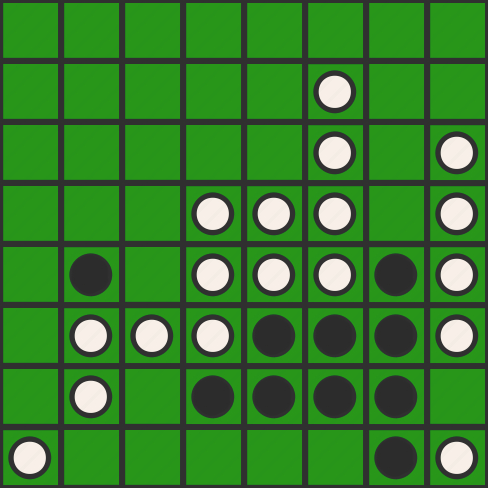

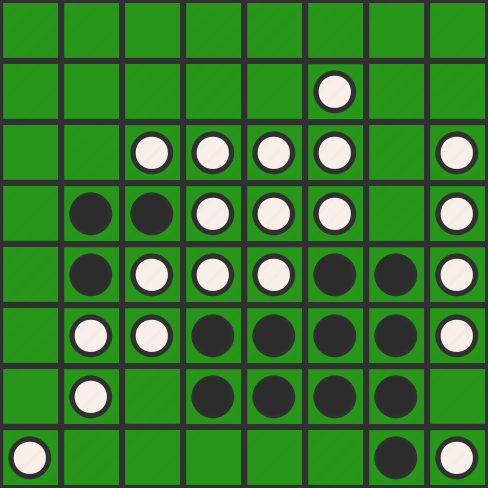

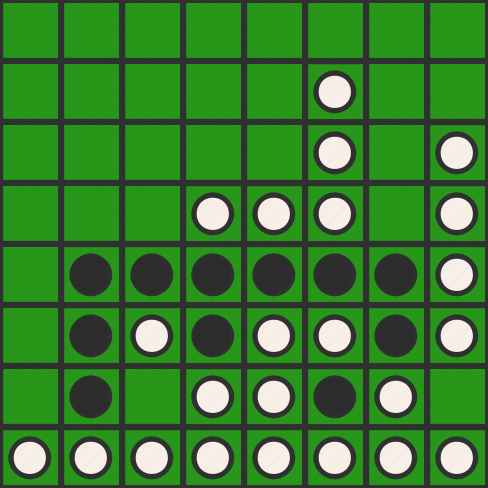

In [13]:
# COUNTERFACTUAL CREATOR (gamestate change)

black_bot = [alphabeta_searcher(2,corners), 'Corner_Bot' ]
white_bot = [maximizer(weighted_score),     'Cleric'     ]


intervention_turn = 30 # keep this even else black will get 2 turns in a row
non_intervention_board,non_cf_game_record = play_games(1,'base_game',black_bot,white_bot,intervention_turn=intervention_turn)

# create the intervention: runs back 'runback' turns, and black plays very strongly, white plays randomly
runback = 6
black_bot_temp = alphabeta_searcher(3,weighted_score)
white_bot_temp =  alphabeta_searcher(3,anti_weighted_score)

runback_record = non_cf_game_record[:-runback]
pre_split_board = board_state_at(runback_record)
post_intervention_board,black_score,record = play(black_bot_temp,white_bot_temp,starting_board = list(pre_split_board),turn_limit = runback)
post_cf_game_record = runback_record + record

display_board(pre_split_board)
display_board(non_intervention_board)
display_board(post_intervention_board)

In [15]:
# COUNTERFACTUAL CREATOR (gamestate change) (continued)

play_games(100,'baseline_games',black_bot,white_bot,
           starting_board      = list(non_intervention_board),
           intervention_record = non_cf_game_record)

print('\n\n\n\n')
play_games(100,'cf_games',black_bot,white_bot,
           starting_board      = list(post_intervention_board),
           intervention_record = post_cf_game_record)

Cleric White
Cleric White
Tie
Tie
Corner_Bot Black
Cleric White
Cleric White
Corner_Bot Black
Cleric White
Cleric White
Corner_Bot Black
Corner_Bot Black
Cleric White
Cleric White
Cleric White
Cleric White
Cleric White
Cleric White
Corner_Bot Black
Cleric White
Tie
Cleric White
Corner_Bot Black
Corner_Bot Black
Corner_Bot Black
Cleric White
Corner_Bot Black
Corner_Bot Black
Cleric White
Cleric White
Corner_Bot Black
Corner_Bot Black
Cleric White
Cleric White
Cleric White
Cleric White
Cleric White
Corner_Bot Black
Corner_Bot Black
Cleric White
Corner_Bot Black
Cleric White
Cleric White
Corner_Bot Black
Cleric White
Cleric White
Cleric White
Cleric White
Corner_Bot Black
Corner_Bot Black
Corner_Bot Black
Corner_Bot Black
Corner_Bot Black
Corner_Bot Black
Cleric White
Corner_Bot Black
Corner_Bot Black
Cleric White
Cleric White
Cleric White
Corner_Bot Black
Cleric White
Cleric White
Corner_Bot Black
Corner_Bot Black
Cleric White
Corner_Bot Black
Corner_Bot Black
Cleric White
Cleric White
C

In [17]:
# COUNTERFACTUAL CREATOR (gamestate change) (continued) this is arbitrary, should be generated in any case

play_games(10,'showcase_games',black_bot,white_bot)

Tie
Cleric White
Cleric White
Cleric White
Cleric White
Corner_Bot Black
Corner_Bot Black
Corner_Bot Black
Cleric White
Tie
done with showcase_games
